### Speed + Accuracy Demonstration
This notebook demonstrates CiMLoop's modeling speed and accuracy compared to
prior work NeuroSim. We run NeuroSim's default macro using ResNet18+ImageNet
for one test image.

### Run NeuroSim

In [1]:
!git clone https://github.com/tanner-andrulis/DNN_NeuroSim_V1.3.git
!cd DNN_NeuroSim_V1.3 && make

Cloning into 'DNN_NeuroSim_V1.3'...


remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (92/92), done.
^Cceiving objects:  31% (125/402), 27.01 MiB | 13.09 MiB/s


### Extract NeuroSim Results

In [ ]:
from _import_scripts import scripts
from scripts.notebook_utils import *
import csv

FILE = f"./DNN_NeuroSim_V1.3/Inference_pytorch/neurosim_out.txt"


def get_dynamic_energy(of: str) -> dict:
    lines = open(FILE, "r").readlines()
    layer2energy = {}
    curr_layer = "None"
    for line in lines:
        if "Estimation of Layer" in line:
            curr_layer = line.strip().split(" ")[-2]
        if "readDynamicEnergy" in line and of in line:
            layer2energy[curr_layer] = float(line.strip().split(" ")[-1][:-2])
        if "Summary" in line:
            break
    return layer2energy


# Modified NeuroSim to put all analog dynamic energy in the ADC. This just makes
# it easy to extract the energy for comparison.
energy_per_layer = list(get_dynamic_energy("ADC").values())

FILES = []
SHAPES = []

for f, s in [
    ("Conv_0_", (224, 224, 3, 7, 7, 64, 1, 2)),
    ("Conv3x3_1_", (56, 56, 64, 3, 3, 64, 0, 1)),
    ("Conv3x3_2_", (56, 56, 64, 3, 3, 64, 0, 1)),
    ("Conv3x3_3_", (56, 56, 64, 3, 3, 64, 0, 1)),
    ("Conv3x3_4_", (56, 56, 64, 3, 3, 64, 0, 1)),
    ("Conv3x3_6_", (56, 56, 64, 3, 3, 128, 0, 2)),
    ("Conv3x3_7_", (28, 28, 128, 3, 3, 128, 0, 1)),
    ("Conv1x1_5_", (56, 56, 64, 1, 1, 128, 0, 2)),
    ("Conv3x3_8_", (28, 28, 128, 3, 3, 128, 0, 1)),
    ("Conv3x3_9_", (28, 28, 128, 3, 3, 128, 0, 1)),
    ("Conv3x3_11_", (28, 28, 128, 3, 3, 256, 0, 2)),
    ("Conv3x3_12_", (14, 14, 256, 3, 3, 256, 0, 1)),
    ("Conv1x1_10_", (28, 28, 128, 1, 1, 256, 0, 2)),
    ("Conv3x3_13_", (14, 14, 256, 3, 3, 256, 0, 1)),
    ("Conv3x3_14_", (14, 14, 256, 3, 3, 256, 0, 1)),
    ("Conv3x3_16_", (14, 14, 256, 3, 3, 512, 0, 2)),
    ("Conv3x3_17_", (7, 7, 512, 3, 3, 512, 0, 1)),
    ("Conv1x1_15_", (14, 14, 256, 1, 1, 512, 0, 2)),
    ("Conv3x3_18_", (7, 7, 512, 3, 3, 512, 0, 1)),
    ("Conv3x3_19_", (7, 7, 512, 3, 3, 512, 1, 1)),
    ("FC_20_", (1, 1, 512, 1, 1, 1000, 0, 1)),
]:
    FILES.append(f"weight{f}.csv")
    FILES.append(f"input{f}.csv")
    SHAPES.append(s)


def parse_csv_file(file_path):
    """
    Given a file path, parse all numbers in the CSV file and return them as a
    list of floats.
    """
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        data = []
        for row in reader:
            for num in row:
                data.append(float(num))

    d = np.array(data)
    if np.min(d) < 0:  # This math works for NeuroSim default values of algo
        d = (d + 1) / 2  # weight range of [-1, 1]
    return np.mean(d)


def get_averages_in_directory(path):
    avg_dict = {}

    for filename in tqdm(FILES):
        if filename.endswith(".csv"):
            average = parse_csv_file(os.path.join(path, filename))
            avg_dict[filename] = average
    return avg_dict


# Define the directory path
dir_path = "DNN_NeuroSim_V1.3/Inference_pytorch/layer_record_ResNet18"

# Generate histograms for all CSV files in the directory
avg_dict = get_averages_in_directory(dir_path)
input_averages = [avg_dict[i] for i in avg_dict.keys() if "input" in i]
weight_averages = [avg_dict[i] for i in avg_dict.keys() if "weight" in i]

100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


### Run CiMLoop
We run three tests using CiMLoop:

1. CiMLoop One-Mapping: To evaluate CiMLoop's speed and accuracy.
2. CiMLoop Non-Data-Value-Dependent: For accuracy comparison, we swap CiMLoop's
   per-layer data-value-dependent model for a non-data-value-dependent model
   model. This simulates the accuracy improvement of CiMLoop relative to
   non-data-value-dependent models (e.g., Timeloop+Accelergy v3, MNSim).
3. CiMLoop 10k Mappings: To demonstrate CiMLoop's high speed per mapping.

In [ ]:
from scripts import *

EXTRA_COMPONENT = """
- !Component # Column readout (ADC)
  name: {}
  <<<: [*component_defaults, *keep_outputs, *no_coalesce]
  subclass: dummy_storage
  attributes: {{width: ENCODED_OUTPUT_BITS, n_bits: width, <<<: *cim_component_attributes}}
"""

# NeuroSim has some extra digital components. For fair comparison, we'll add as
# many components it has. We're not using them for energy so we'll just realize
# all of them as intadders.
EXTRA_NEUROSIM_COMPONENTS = ["shift_add", "adder", "pooling", "activation"]
EXTRA_COMPONENTS_CONFIG = "\n".join(
    EXTRA_COMPONENT.format(name) for name in EXTRA_NEUROSIM_COMPONENTS
)


def run_layer(
    dnn: str,
    layer: str,
    avg_input: float,
    avg_weight: float,
    shape: tuple,
    max_mappings: int = None,
):
    spec = get_spec(
        "basic_analog",
        system="ws_dummy_buffer_many_macro",
        dnn=dnn,  # Set the DNN and layer
        layer=layer,
        jinja_parse_data={
            "cell_override": "rram_neurosim_default.cell.yaml",
            "ignoreme_placeholder": EXTRA_COMPONENTS_CONFIG,
        },
    )

    # NeuroSim's default macro variable settings
    spec.variables.update(
        dict(
            INPUT_ENCODING_FUNC="offset_encode_if_signed_hist",
            WEIGHT_ENCODING_FUNC="offset_encode_if_signed_hist",
            VOLTAGE=0.85,
            TECHNOLOGY=22,  # nm
            BITS_PER_CELL=2,
            ADC_RESOLUTION=5,
            VOLTAGE_DAC_RESOLUTION=1,
            TEMPORAL_DAC_RESOLUTION=1,
            N_SHIFT_ADDS_PER_BANK=16,
            N_ADC_PER_BANK=16,
            BASE_LATENCY=1e-12,  # For near-zero leakage, make it really fast.
            READ_PULSE_WIDTH=1e-8,
            VOLTAGE_ENERGY_SCALE=1,
            VOLTAGE_LATENCY_SCALE=1,
            AVERAGE_INPUT_VALUE=float(avg_input),
            AVERAGE_WEIGHT_VALUE=float(avg_weight),
            BATCH_SIZE=1,
        )
    )
    spec.architecture.find("row").spatial.meshY = 128
    spec.architecture.find("column").spatial.meshX = 128
    spec.architecture.find("adc").attributes[
        "adc_estimator_plug_in"
    ] = '"Neurosim Plug-In"'

    # Set the shape of the layer. NeuroSim uses a different shape than Timeloop
    spec.variables["MAX_UTILIZATION"] = False
    ins = spec.problem.instance
    ins["P"] = (shape[0] - shape[3] + 1) // shape[7]
    ins["Q"] = (shape[1] - shape[4] + 1) // shape[7]
    ins["C"] = shape[2]
    ins["R"] = shape[3]
    ins["S"] = shape[3]
    ins["M"] = shape[5]
    ins["WStride"] = shape[7]
    ins["HStride"] = shape[7]

    # Lock in the mapping to only evaluate one mapping by defualt
    dt = spec.architecture.find("dummy_top").constraints.temporal
    dt.factors_only = dt.factors
    dt.factors.clear()
    dt.factors_only.add_eq_factor("X", 8)
    dt.factors_only.add_eq_factor("P", -1)
    dt.factors_only.add_eq_factor("Q", -1)
    spec.mapping.max_permutations_per_if_visit = 1

    # If there's a max_mappings, expand the search space
    if max_mappings is not None:
        # Set to evaluate max_mappings mappings
        spec.mapper.search_size = max_mappings
        spec.mapper.max_permutations_per_if_visit = max_mappings
        spec.mapper.victory_condition = max_mappings

        # Expand the problem and relax constraints to expand the search space
        for d in "RSMCPQXYZG":
            spec.problem.instance[d] = 8
        for t in ["row", "column", "macro", "dummy_top", "1bit_x_1bit_mac"]:
            t = spec.architecture.find(t)
            t.constraints.spatial.permutation.clear()
            t.constraints.temporal.permutation.clear()

    # Some specific mappings needed to match NeuroSim. Timeloop will find a
    # lower-energy mapping if we don't set these.
    if ins["C"] == 64:
        rs = spec.architecture.find("row").constraints.spatial
        rs.factors.clear()
        rs.factors_only = rs.factors
        rs.factors_only.add_eq_factor("C", 64)
        rs.factors_only.add_eq_factor("R", 1)
        rs.factors_only.add_eq_factor("S", 1)
        rs.maximize_dims = None

    # Run the mapper
    return run_mapper_parse_output(spec, "my_spec")


DNN = "resnet18"
layers = [f for f in os.listdir(f"../models/workloads/{DNN}") if f != "index.yaml"]
layers = sorted(l.split(".")[0] for l in layers)

# # CiMLoop One Mapping
start_time_one_mapping = time.time()
results = joblib.Parallel(n_jobs=32)(
    joblib.delayed(run_layer)(DNN, layer, avg_input, avg_weight, shape)
    for layer, avg_input, avg_weight, shape in zip(
        layers, input_averages, weight_averages, SHAPES
    )
)
end_time_one_mapping = time.time()

# # CiMLoop Non-Data Value Dependent
overall_avg_input = np.mean(input_averages)
overall_avg_weight = np.mean(weight_averages)
non_data_value_dependent_results = joblib.Parallel(n_jobs=32)(
    joblib.delayed(run_layer)(DNN, layer, overall_avg_input, overall_avg_weight, shape)
    for layer, shape in zip(layers, SHAPES)
)

# CiMLoop 10k mappings
start_time_10k_mappings = time.time()
results_10k_mappings = joblib.Parallel(n_jobs=32)(
    joblib.delayed(run_layer)(DNN, layer, avg_input, avg_weight, shape, 10000)
    for layer, avg_input, avg_weight, shape in zip(
        layers, input_averages, weight_averages, SHAPES
    )
)
end_time_10k_mappings = time.time()

### Organize and Display Results

Speed Comparison ((Mappings x Layers) per Second):
	 NeuroSim : 0.1227
	 CiMLoop 1 Mapping: 3.9211
	 CiMLoop 10k Mappings: 2384.2396
Average Energy Error Comparison:
	 CiMLoop: 2.96%
	 CiMLoop Non-Data Value Dependent: 28.34%
Max Energy Error Comparison:
	 CiMLoop: 7.26%
	 CiMLoop Non-Data Value Dependent: 69.76%


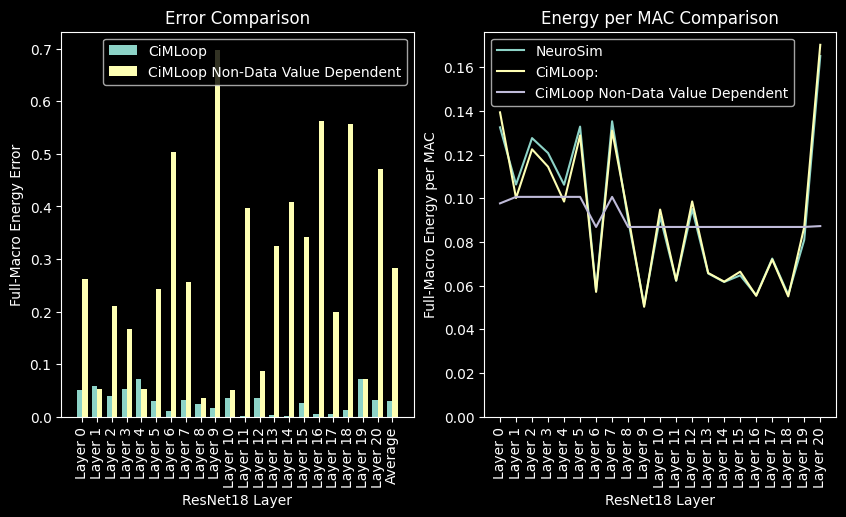

In [ ]:
organized = {
    f"Layer {i}": {
        "CiMLoop": abs(e - r1.total_energy) / e,
        "CiMLoop Non-Data Value Dependent": abs(e - r2.total_energy) / e,
    }
    for i, (e, r1, r2) in enumerate(
        zip(energy_per_layer, results, non_data_value_dependent_results)
    )
}

organized["Average"] = {
    "CiMLoop": np.mean([v["CiMLoop"] for v in organized.values()]),
    "CiMLoop Non-Data Value Dependent": np.mean(
        [v["CiMLoop Non-Data Value Dependent"] for v in organized.values()]
    ),
}

energy_per_mac = {
    f"Layer {i}": {
        "NeuroSim": e / r0.macs,
        "CiMLoop:": r0.total_energy / r0.macs,
        "CiMLoop Non-Data Value Dependent": r1.total_energy / r1.macs,
    }
    for i, (e, r0, r1) in enumerate(
        zip(energy_per_layer, results, non_data_value_dependent_results)
    )
}

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
bar_side_by_side(
    organized,
    xlabel="ResNet18 Layer",
    ylabel="Full-Macro Energy Error",
    title="Error Comparison",
    ax=ax[0],
)
plot(
    energy_per_mac,
    xlabel="ResNet18 Layer",
    ylabel="Full-Macro Energy per MAC",
    title="Energy per MAC Comparison",
    ax=ax[1],
)

mappings_per_layer_per_second = {
    "": {
        "NeuroSim": 20
        / int(
            re.search(r"(?<=Total Run-time of NeuroSim: )\d+", open(FILE).read()).group(
                0
            )
        ),
        "CiMLoop One Mapping": len(results)
        / (end_time_one_mapping - start_time_one_mapping),
        "CiMLoop 10k Mappings": 1e4
        * len(results_10k_mappings)
        / (end_time_10k_mappings - start_time_10k_mappings),
    }
}
neurosim_time = int(
    re.search(r"(?<=Total Run-time of NeuroSim: )\d+", open(FILE).read()).group(0)
)
print(f"Speed Comparison ((Mappings x Layers) per Second):")
print(f"\t NeuroSim : {20 / neurosim_time:.4f}")
print(
    f"\t CiMLoop 1 Mapping: {20 / (end_time_one_mapping - start_time_one_mapping):.4f}"
)
print(
    f"\t CiMLoop 10k Mappings: {1e4 * len(results_10k_mappings) / (end_time_10k_mappings - start_time_10k_mappings):.4f}"
)
print(f"Average Energy Error Comparison:")
print(f'\t CiMLoop: {organized["Average"]["CiMLoop"] * 100:.2f}%')
print(
    f'\t CiMLoop Non-Data Value Dependent: {organized["Average"]["CiMLoop Non-Data Value Dependent"] * 100:.2f}%'
)
print(f"Max Energy Error Comparison:")
print(f'\t CiMLoop: {max(v["CiMLoop"] for v in organized.values()) * 100:.2f}%')
print(
    f'\t CiMLoop Non-Data Value Dependent: {max(v["CiMLoop Non-Data Value Dependent"] for v in organized.values()) * 100:.2f}%'
)